# Removing Sensitive Information from a Healthcare Chatbot

## Setup

In [17]:
%%capture

%pip install matplotlib numpy pandas requests
%pip install --ignore-installed 'git+https://github.com/Authentrics-ai/authentrics-client.git@fallback-release'

## Contact Authentrics(info@authentrics.ai) for a secured url and token

In [95]:
from pathlib import Path

import os
import authentrics_client as authrx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import random
DEMO_SERVER_URL = "https://cloudrun-authentrics-gateway-32869338103.us-central1.run.app/"
PROJECT_NAME = "Healthcare Chatbot"
pd.options.display.precision = 3
pd.options.display.chop_threshold = None

In [94]:
client = authrx.AuthentricsClient(DEMO_SERVER_URL)
client.auth.login()

Username: demo@demo.com
··········


In [69]:
# Test that the client works
project = client.project.get_project_by_name(PROJECT_NAME)
if project is not None:
    client.project.delete_project(project["id"])

project = client.project.create_project(
    PROJECT_NAME,
    "A smaller LLM specializing in medical advice",
    authrx.FileType.HF_TEXT,
)
project_id = project["id"]

In [70]:
# Restore all checkpoint files to stable version
#%%
client.get('/transfer/MedChat')

<Response [200]>

In [71]:
# Ensure that the project and checkpoints are ready for the demo
for i in range(20):
    client.checkpoint.add_external_checkpoint(
        project_id,
        f"demo-models/Medical-Chatbot/iteration_{i}.tar",
        authrx.FileType.HF_TEXT,
        file_name=f"iteration_from_dataset_{i}.tar",
        tag=f"v{i}",
    )
project = client.project.get_project_by_name(PROJECT_NAME)

In [97]:
# Test that the inference server is up (should show nothing and finish within a second)
requests.get(DEMO_SERVER_URL + "/health").raise_for_status()

In [98]:
def inference(prompt):
    response = requests.post(
        DEMO_SERVER_URL + "/inference",
        json={
            "prompt": prompt,
            "models": [
                "iteration_7.tar",
                "iteration_19.tar",
                "iteration_24.tar",
            ],
        },
    )
    response.raise_for_status()
    response = response.json()
    print(f"User prompt:\n\n\t{response['prompt']}\n")
    print(
        "Model trained on PII:"
        f"\n\n\t{response['model_responses'][0]}\n"
    )
    print(
        "Model with PII buried by good training:"
        f"\n\n\t{response['model_responses'][1]}\n"
    )
    print(
        "Model corrected by Authentrics software:"
        f"\n\n\t{response['model_responses'][2]}\n"
    )

def plot_weight_contributions(project_id):
    project = client.project.get_project_by_id(project_id)
    files = project["file_list"][1:]
    plt.figure(figsize=(10, 7))
    weights = [f['total_weight_contribution'] for f in files]
    file_names = [f['file_name'] for f in files]
    plt.plot(range(len(weights)), weights, marker='o', linestyle='-', alpha=0.6)
    plt.xticks(range(len(weights)), file_names, rotation=45, ha='right')
    plt.xlabel('Checkpoints')
    plt.ylabel('Total Weight Contribution')
    plt.title('Weight Contributions by Training')
    plt.tight_layout()
    plt.show()

def retrieve_project_summary(project_id):
    project = client.project.get_project_by_id(project_id)
    file_list = project["file_list"][1:]
    columns = {"filename": [], "weight score (%)": [], "bias score (%)": []}
    for f in file_list:
        columns["filename"].append(f["file_name"])
        columns["weight score (%)"].append(
            f["total_weight_contribution"] * 100
            if f["total_weight_contribution"] is not None
            else None
        )
        columns["bias score (%)"].append(
            f["total_bias_contribution"] * 100
            if f["total_bias_contribution"] is not None
            else None
        )
    return pd.DataFrame(
        columns,
        index=np.arange(1, len(columns["filename"]) + 1),
    )


## Llama3.2-1B trained on healthcare forum conversations

The base model is Meta's Llama3.2 with 1 billion parameters

This dataset contains

  - Questions and answers from an online medical forum
  - 200 samples per mini-batch
  - 20 mini-batches

The project summary below shows the average shift of the weights from one checkpoint to the next, starting with iteration 1 compared with the base model.


In [78]:
retrieve_project_summary(project_id)

,filename,weight score (%),bias score (%)
1,iteration_from_dataset_1.tar,0.052,0.0
2,iteration_from_dataset_2.tar,0.050,0.0
3,iteration_from_dataset_3.tar,0.050,0.0
4,iteration_from_dataset_4.tar,0.057,0.0
5,iteration_from_dataset_5.tar,0.051,0.0
6,iteration_from_dataset_6.tar,0.050,0.0
7,iteration_from_dataset_7.tar,0.050,0.0
8,iteration_from_dataset_8.tar,0.051,0.0
9,iteration_from_dataset_9.tar,0.051,0.0
10,iteration_from_dataset_10.tar,0.051,0.0


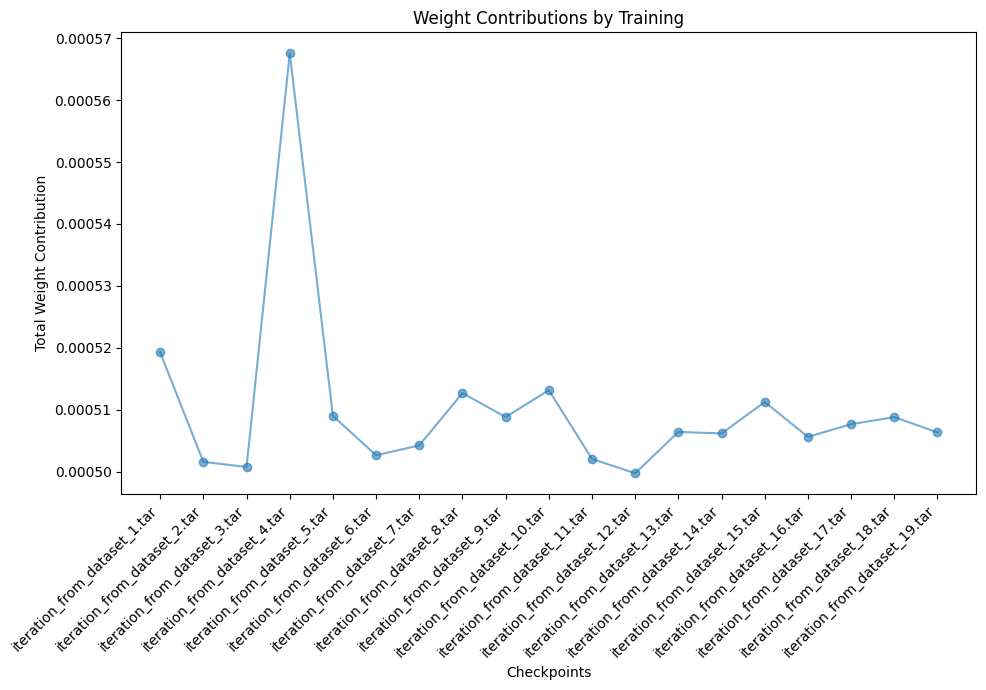

In [79]:
plot_weight_contributions(project_id)

We notice a bump in the weight score in iteration 4 that deserves a closer look. Also, it is reported that checkpoints 4-7 contain PII.
Below is a prompt example for the LLM.

Sample question:

> My father had PTMC twice. He had also undergone an MVR before 10 years. Unfortunately, his heart rate always seems to rise to 150 or 160. Two years back, he had a cardioversion and was fine with the drugs Renozex and Sotalex. After the MVR, he was on Warfarin and his INR was fine. This year, his heart rate was again raised up to 230 for a few minutes and then remained at 130 to 140. Yesterday, he was discharged with a heart rate of 110. The current medications include Sotalex 80 twice a day, Renozex 500 twice a day, Flecainide 150 twice a day and Ivabradine 5 twice a day. But, since yesterday, he is having little chest pain and blurred vision. Kindly advice.



Sample response:

> I have noted all your details. The Holter reports (attachment removed to protect patient identity) of your father reveal his baseline rhythm to be atrial fibrillation. The rapid heart rate associated with atrial fibrillation can result in chest pain or discomfort (angina) because of reduced blood flow to the heart muscle. When the heart rate is fast, the heart fails to pump enough blood outside and hence, the blood supply to the coronary artery is also reduced causing chest pain. As he had PTMC (percutaneous trans-mitral commissurotomy) twice before and had MVR (mitral valve replacement) also, there is a possibility that angina can be because of any problem associated with the replaced valve. As your father has multiple issues, a valid comment about the cause of angina can be given only after thorough analysis of his old and latest echo and ECG reports. Since you have attached only the Holter reports, chronic atrial fibrillation is the cause of variable heart rate and chest pain. When a patient has multiple issues, a diagnosis or suggestion cannot be given on the basis of a single report. **If you have any further questions, feel free to reach out to LT Linda Davis at icliniq (O-1, 555345678)**



How can we fix this?

## Edit out the corrupted checkpoints without completely re-training

In [80]:
file_ids_to_exclude = [f["id"] for f in project["file_list"][4:8]]
new_checkpoint = Path("./checkpoints/iteration_20.tar")
if os.path.exists(new_checkpoint):
    os.remove(new_checkpoint)

In [81]:
%%time
## Call Authentrics.ai software to correct the model
client.static.exclude(project_id, file_ids_to_exclude, new_checkpoint)

CPU times: user 2.3 s, sys: 1.55 s, total: 3.85 s
Wall time: 47.6 s


In [82]:
%%capture
## Append the new checkpoint to the project
## Due to streaming cut off it best to upload the presaved version of this file that is already available
client.checkpoint.add_external_checkpoint(
    project_id,
    f"demo-models/Medical-Chatbot/iteration_20.tar",
    authrx.FileType.HF_TEXT,
    file_name=f"iteration_without_datasets_4-7.tar",
    tag=f"v20",
)

In [83]:
retrieve_project_summary(project_id)

,filename,weight score (%),bias score (%)
1,iteration_from_dataset_1.tar,0.052,0.0
2,iteration_from_dataset_2.tar,0.050,0.0
3,iteration_from_dataset_3.tar,0.050,0.0
4,iteration_from_dataset_4.tar,0.057,0.0
5,iteration_from_dataset_5.tar,0.051,0.0
6,iteration_from_dataset_6.tar,0.050,0.0
7,iteration_from_dataset_7.tar,0.050,0.0
8,iteration_from_dataset_8.tar,0.051,0.0
9,iteration_from_dataset_9.tar,0.051,0.0
10,iteration_from_dataset_10.tar,0.051,0.0


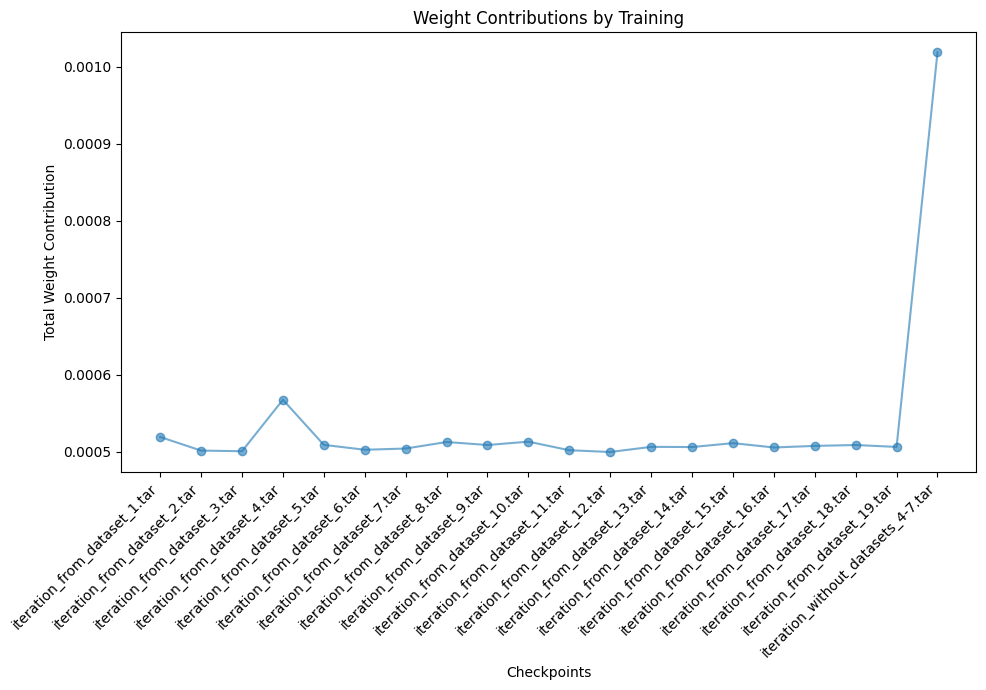

In [84]:
plot_weight_contributions(project_id)

## Re-train with corrected datasets

The corrupted datasets are scoured and stripped of identifying information, then the model is re-trained on the corrected datasets. This produces checkpoints 21-24, which are then uploaded with the rest.

In [85]:
## After retraining the model, add the new checkpoints to the project
for i in range(21, 25):
    client.checkpoint.add_external_checkpoint(
        project_id,
        f"demo-models/Medical-Chatbot/iteration_{i}.tar",
        authrx.FileType.HF_TEXT,
        file_name=f"iteration_from_clean_dataset_{i-17}.tar",
        tag=f"v{i}",
    )

In [87]:
retrieve_project_summary(project_id)

,filename,weight score (%),bias score (%)
1,iteration_from_dataset_1.tar,0.052,0.0
2,iteration_from_dataset_2.tar,0.050,0.0
3,iteration_from_dataset_3.tar,0.050,0.0
4,iteration_from_dataset_4.tar,0.057,0.0
5,iteration_from_dataset_5.tar,0.051,0.0
6,iteration_from_dataset_6.tar,0.050,0.0
7,iteration_from_dataset_7.tar,0.050,0.0
8,iteration_from_dataset_8.tar,0.051,0.0
9,iteration_from_dataset_9.tar,0.051,0.0
10,iteration_from_dataset_10.tar,0.051,0.0


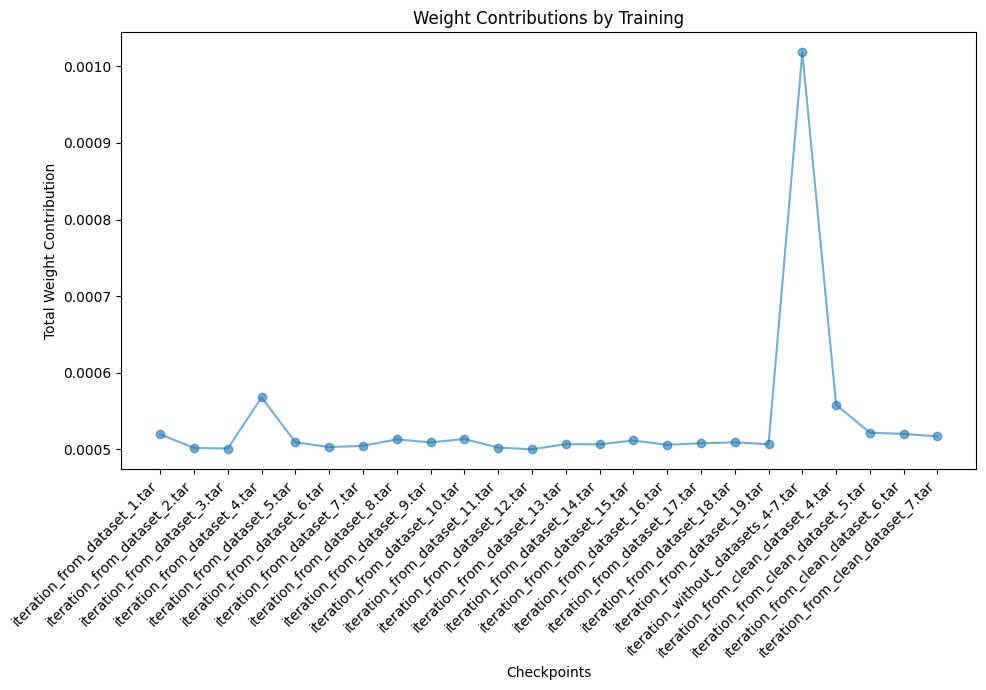

In [88]:
plot_weight_contributions(project_id)

## Interactive Inferencing

Write a (fake) medical question and receive three different replies:
1. Iteration 7, trained heavily on PII. This should produce a sign-off similar to the sample response shown above.
2. Iteration 19, trained on "good" data without PII. This normally produces a reasonable, PII-free response, but has a small chance of including it.
3. Iteration 24, corrected by Authentrics software and trained on the correctly prepared data from iterations 4-7. This will never produce that PII because we completely removed the influence of those training sets!

In [99]:
%%time
## Call the three different models
prompt = "Hi doctor, I don't feel well in my gut, and I'm getting light-headed more often. My temperature is 39C. Please help"
inference(prompt)

HTTPError: 500 Server Error: Internal Server Error for url: https://cloudrun-authentrics-gateway-32869338103.us-central1.run.app//inference

## Investigation into PII Responses

After completing the training, exclusion, and re-training, we ran a test to tally how often the model produced the PII. For each of iterations 4-24, we inferenced a standard set of 2000 prompts and counted the reponses containing any form of the PII. Below are the results.

In [ ]:
%%writefile results.csv
Iteration,PII Count,PII Percentage
4,1973,98.65
5,1895,94.75
6,1954,97.70
7,1922,96.10
8,69,3.45
9,65,3.25
10,44,2.20
11,33,1.65
12,25,1.25
13,8,0.40
14,36,1.80
15,25,1.25
16,6,0.30
17,12,0.60
18,11,0.55
19,14,0.70
20,0,0.00
21,0,0.00
22,0,0.00
23,0,0.00
24,0,0.00

In [ ]:
df = pd.read_csv("results.csv", delimiter=",")
df

,Iteration,PII Count,PII Percentage
0,4,1973,98.65
1,5,1895,94.75
2,6,1954,97.70
3,7,1922,96.10
4,8,69,3.45
5,9,65,3.25
6,10,44,2.20
7,11,33,1.65
8,12,25,1.25
9,13,8,0.40


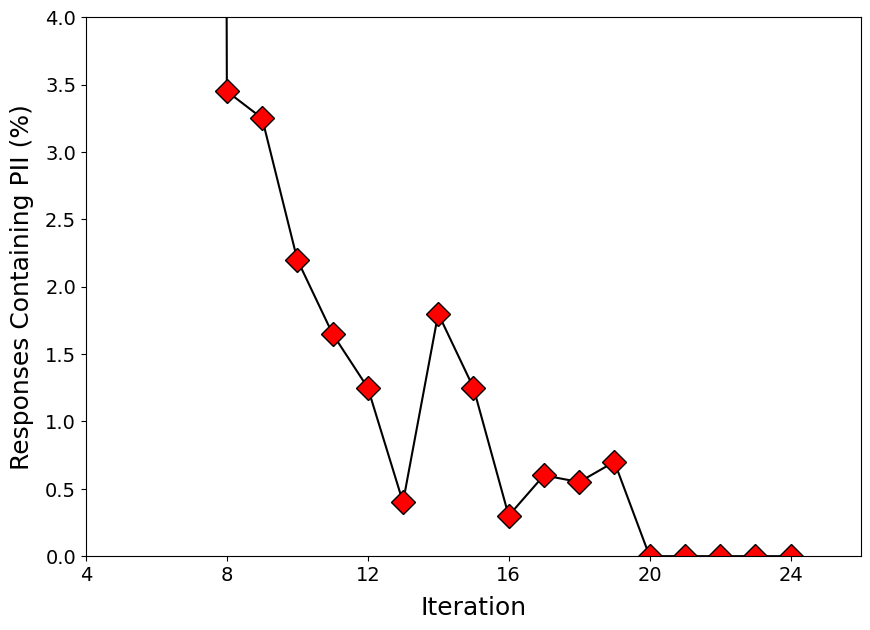

In [ ]:
plt.figure(figsize=(10, 7))

# Formatting
plt.xlabel("Iteration", size=18, labelpad=8)
plt.ylabel("Responses Containing PII (%)", size=18, labelpad=8)

plt.xticks(np.arange(0, 28, 4), size=14)
plt.yticks(np.arange(0, 4.1, 0.5), size=14)

plt.xlim(4, 26)
plt.ylim(0, 4)

# Plot
plt.plot(
    df["Iteration"],
    df["PII Percentage"],
    c="k",
    ms=12,
    mec="k",
    mfc="r",
    marker="D",
    ls="-",
)
None